In [ ]:
# Shuo Chen
# 301180465

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import norm
import tensorflow as tf
from tensorflow import keras
from numpy.random import seed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,roc_curve, recall_score, classification_report, f1_score,precision_recall_fscore_support)
import h5py
seed(1)
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
!pip install tensorflow==1.14.0
!pip install keras==2.2.4

In [130]:
print('TensorFlow version: ', tf.__version__)
print('Keras version: ', keras.__version__)

TensorFlow version:  1.14.0
Keras version:  2.2.4-tf


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving network_attack_data.csv to network_attack_data.csv


In [131]:
# read dataset
data = pd.read_csv('network_attack_data.csv') 
data.head()

,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,F_10,...,F_68,F_69,F_70,F_71,F_72,F_73,F_74,F_75,F_76,Label
0,109998919,4,3,525,0.0,520,0,131.25,259.177385,0,...,32,5735.0,0.0,5735.0,5735.0,110000000.0,0.0,110000000.0,110000000.0,1
1,109993343,4,3,531,0.0,520,0,132.75,258.218738,0,...,32,5437.0,0.0,5437.0,5437.0,110000000.0,0.0,110000000.0,110000000.0,1
2,109988359,4,3,535,0.0,520,0,133.75,257.597069,0,...,32,5505.0,0.0,5505.0,5505.0,110000000.0,0.0,110000000.0,110000000.0,1
3,109982960,4,3,530,0.0,520,0,132.50,258.376341,0,...,32,5303.0,0.0,5303.0,5303.0,110000000.0,0.0,110000000.0,110000000.0,1
4,109977744,4,3,530,0.0,520,0,132.50,258.376341,0,...,32,5356.0,0.0,5356.0,5356.0,110000000.0,0.0,110000000.0,110000000.0,1


In [132]:
data['Label'].value_counts() 

0    22987
1     5498
Name: Label, dtype: int64

In [133]:
# save benign and attack dataframe separately
benign = data[data['Label']== 0]
attack= data[data['Label']!= 0]

In [134]:
# convert benign and attack dataframes to numpy arrays after dropping the label
x_benign = benign.drop('Label',axis=1).values 
y_benign = benign['Label'].values

x_attack = attack.drop('Label',axis=1).values 
y_attack = attack['Label'].values

In [135]:
# split the data into test and train
x_benign_train, x_benign_test = train_test_split(x_benign, test_size=0.25, random_state=40)

In [136]:
# scale the train and test data using Standard Scalar
scaler = StandardScaler()
x_benign_train_scaled= scaler.fit_transform(x_benign_train) 
x_benign_test_scaled= scaler.transform(x_benign_test) 
x_attack_scaled= scaler.transform(x_attack) 

In [137]:
# set hyperparameter
batch_size = 32
original_dim = 76
latent_dim = 10
neuron_num = 50
epochs = 100
epsilon_std = 1.0

In [138]:
# define encoder with 2 hidden layers
x = keras.layers.Input(shape=(original_dim,))
h1 = keras.layers.Dense(neuron_num, activation='relu')(x)
h2 = keras.layers.Dense(neuron_num, activation='relu')(h1)
z_mean = keras.layers.Dense(latent_dim)(h2) 
z_log_var = keras.layers.Dense(latent_dim)(h2) 

In [139]:
# define sampling layer
K = keras.backend

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0, stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

#Latent layer
z = keras.layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

encoder = keras.Model(x,[z_mean,z_log_var,z],name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 76)]         0                                            
__________________________________________________________________________________________________
dense_35 (Dense)                (None, 50)           3850        input_6[0][0]                    
__________________________________________________________________________________________________
dense_36 (Dense)                (None, 50)           2550        dense_35[0][0]                   
__________________________________________________________________________________________________
dense_37 (Dense)                (None, 10)           510         dense_36[0][0]                   
____________________________________________________________________________________________

In [140]:
# define decoder with 2 hidden layers
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
decoder_h1 = keras.layers.Dense(neuron_num, activation='relu')(latent_inputs)
decoder_h2 = keras.layers.Dense(neuron_num, activation='relu')(decoder_h1) 

decoder_mean = keras.layers.Dense(original_dim)
x_decoded_mean = decoder_mean(decoder_h2)

decoder = keras.Model(latent_inputs,x_decoded_mean,name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 10)]              0         
_________________________________________________________________
dense_39 (Dense)             (None, 50)                550       
_________________________________________________________________
dense_40 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_41 (Dense)             (None, 76)                3876      
Total params: 6,976
Trainable params: 6,976
Non-trainable params: 0
_________________________________________________________________


In [141]:
# instantiate VAE model
output = decoder(encoder(x)[2])
vae = keras.models.Model(x, output, name = 'VAE')

In [142]:
# define VAE loss function
def vae_loss(feature, reconstructed):
    reconstruction_loss = keras.losses.binary_crossentropy(feature, reconstructed)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return reconstruction_loss + kl_loss

In [143]:
# compile the model
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss=vae_loss)
vae.summary()

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 76)]              0         
_________________________________________________________________
encoder (Model)              [(None, 10), (None, 10),  7420      
_________________________________________________________________
decoder (Model)              (None, 76)                6976      
Total params: 14,396
Trainable params: 14,396
Non-trainable params: 0
_________________________________________________________________


In [144]:
# train VAE model
history= vae.fit(x_benign_train_scaled ,x_benign_train_scaled, verbose = 1, batch_size=batch_size, epochs=epochs,shuffle=True,validation_split=0.2)

Train on 13792 samples, validate on 3448 samples
Epoch 1/100
13792/13792 [==============================] - 2s 165us/sample - loss: 52.6889 - val_loss: -1.1988
Epoch 2/100
13792/13792 [==============================] - 1s 96us/sample - loss: -1.4537 - val_loss: -1.6861
Epoch 3/100
13792/13792 [==============================] - 1s 100us/sample - loss: -1.7401 - val_loss: -1.8524
Epoch 4/100
13792/13792 [==============================] - 1s 98us/sample - loss: -1.8009 - val_loss: -1.8734
Epoch 5/100
13792/13792 [==============================] - 1s 96us/sample - loss: -1.7775 - val_loss: -1.5235
Epoch 6/100
13792/13792 [==============================] - 1s 101us/sample - loss: -1.8655 - val_loss: -2.0412
Epoch 7/100
13792/13792 [==============================] - 1s 101us/sample - loss: -1.9627 - val_loss: -1.9682
Epoch 8/100
13792/13792 [==============================] - 1s 98us/sample - loss: -1.9997 - val_loss: -2.1330
Epoch 9/100
13792/13792 [==============================] - 1s 104us

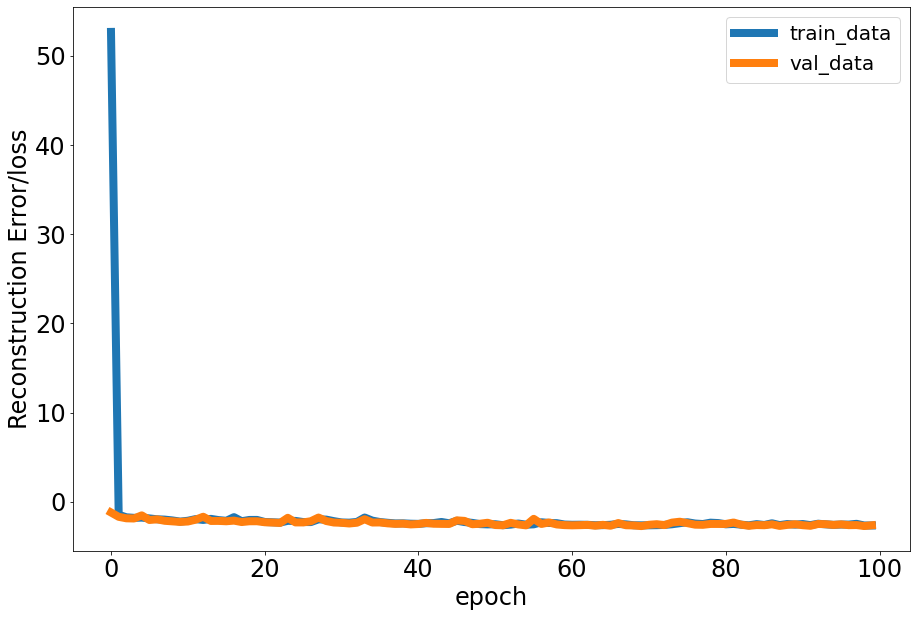

In [145]:
# plot loss curve
mpl.rcParams['font.size'] = 24
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(history.history['loss'],linewidth = 8)
plt.plot(history.history['val_loss'],linewidth = 8)
plt.ylabel('Reconstruction Error/loss',fontsize = 24)
plt.xlabel('epoch',fontsize = 24)
plt.legend(['train_data', 'val_data'], loc='best',fontsize = 20)
plt.show()

In [146]:
# save models
encoder.save("Encoder.h5")
decoder.save("Decoder.h5")
vae.save("VAE.h5")

In [147]:
history.params

{'batch_size': 32,
 'do_validation': True,
 'epochs': 100,
 'metrics': ['loss', 'val_loss'],
 'samples': 13792,
 'steps': None,
 'verbose': 0}

In [148]:
# predict on test data
pred1 = vae.predict(x_benign_train_scaled) # predictions on train normal data
score1 = np.sqrt(metrics.mean_squared_error(pred1,x_benign_train_scaled))

pred2 = vae.predict(x_benign_test_scaled) # predictions on test normal data
score2 = np.sqrt(metrics.mean_squared_error(pred2,x_benign_test_scaled))

pred3 = vae.predict(x_attack_scaled) # predictions on test fraud data
score3 = np.sqrt(metrics.mean_squared_error(pred3,x_attack_scaled))

print(f"Normal_training_data Score (RMSE): {score1}")
print(f"Normal_test_data_score Score (RMSE): {score2}")
print(f"Fraud_test_data_score (RMSE): {score3}")

Normal_training_data Score (RMSE): 2.700519939623218
Normal_test_data_score Score (RMSE): 2.707517003665148
Fraud_test_data_score (RMSE): 5.071516922560458


In [149]:
test_obs = x_benign_test_scaled.copy() # create a copy of normal data and save in tst_obs
print(test_obs.shape)
test_obs = np.append(test_obs, x_attack_scaled, axis=0) ##combine test normal and test fraud data
print(test_obs.shape)
print(y_benign[0:5747].shape)

(5747, 76)
(11245, 76)
(5747,)


In [150]:
Y_obs = y_benign[0:5747].copy() # create a copy of normal labels and save in Y_obs
Y_obs  = np.append(Y_obs, y_attack, axis=0)
print(Y_obs.shape)

(11245,)


In [151]:
test_preds=vae.predict(test_obs)
mse_test = np.mean(np.power(test_obs- test_preds, 2), axis=1)

In [152]:
test_error_data = pd.DataFrame({'recon_error': mse_test,'Class': Y_obs})

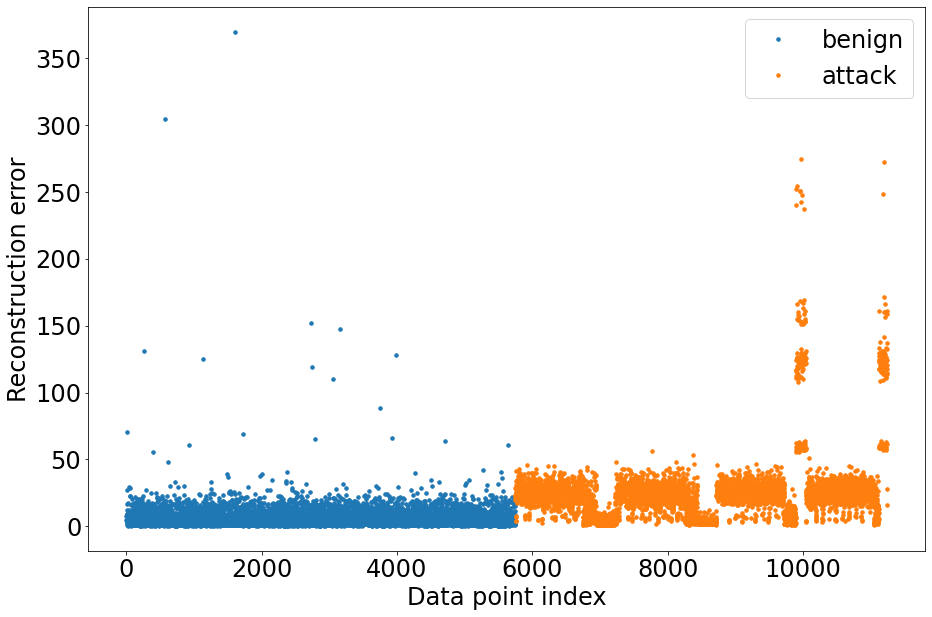

In [153]:
group1 = test_error_data.groupby('Class')
fig, ax = plt.subplots()
for name, group in group1:
    ax.plot(group.index, group.recon_error, marker='o', ms=3.5, linestyle='',label= "attack" if name == 1 else "benign")
ax.legend()
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

In [154]:
# Metric analysis
threshold=10

y_pred = [1 if e > threshold else 0 for e in test_error_data.recon_error.values]

cm= confusion_matrix(test_error_data.Class, y_pred)
print("Confusion matrix:")
print(cm)

tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]

print("\nTotal number of true positives", tp)
print("Total number of false negatives",fn)
print("Total number of false positives",fp)
print("Total number of true negatives",tn)

acc=float(tp+tn)/(tp+tn+fp+fn)

print('\nClassifier Accuracy: %.2f%%' % (acc * 100))

tpr = float(tp)/(tp+fn)

print('True Positive Rate (TPR/Recall/Sensitivity): %.2f%%' % (tpr * 100))

specificity = float (tn)/(tn+fp)

print ("True Negative Rate (TNR/Specificity/selectivity):%.2f%%" % (specificity*100)) 

fpr = float(fp)/(fp+tn)
print("False Positive Rate (FPR): %.2f%%" % (fpr * 100))

fnr = fn/ (fn+ tp)
print("False Negative Rate (FNR): %.2f%%" % (fnr*100))

precision=float(tp)/(tp+fp)
print("Precision/Positive Predictive value:%.2f%%" %(precision*100))

fscore = 2*((precision*tpr)/(precision+tpr))
print("F1-Score: %.2f%%" %(fscore*100))

Confusion matrix:
[[4352 1395]
 [1066 4432]]

Total number of true positives 4432
Total number of false negatives 1066
Total number of false positives 1395
Total number of true negatives 4352

Classifier Accuracy: 78.11%
True Positive Rate (TPR/Recall/Sensitivity): 80.61%
True Negative Rate (TNR/Specificity/selectivity):75.73%
False Positive Rate (FPR): 24.27%
False Negative Rate (FNR): 19.39%
Precision/Positive Predictive value:76.06%
F1-Score: 78.27%


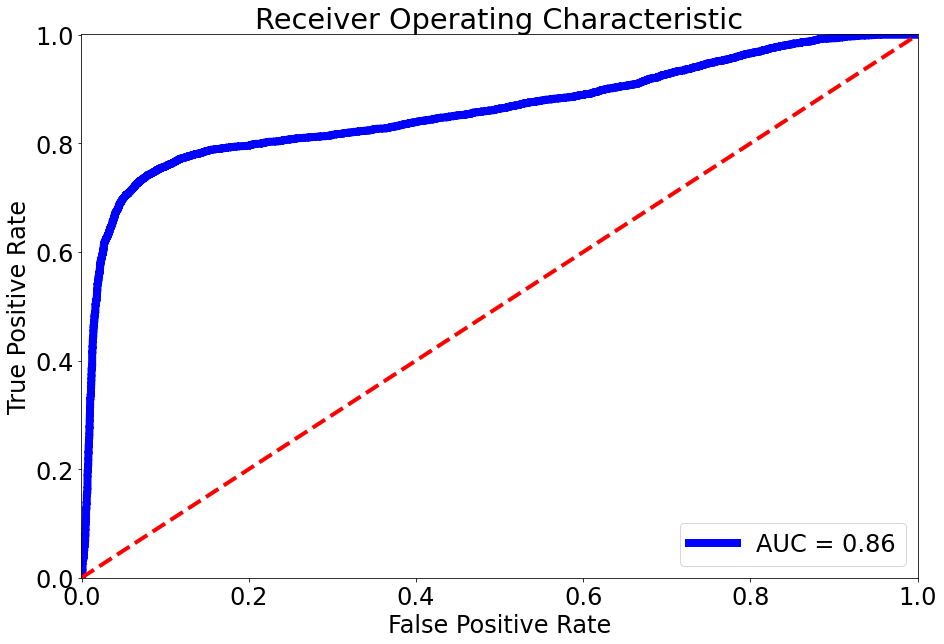

In [155]:
# ROC-AUC curve
fpr, tpr, thresholds = roc_curve(test_error_data.Class,test_error_data.recon_error)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.2f'% roc_auc,linewidth = 8, color='b')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--',linewidth = 4)
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()